<a href="https://www.kaggle.com/code/ftimagouveia/research-assistant-chatbot?scriptVersionId=237042596" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Capstone Project: Research Assistant Chatbot

*Capstone project developed on the scope of the Kaggle 5-day Generative AI course (2025).*

## Project Overview

The **Research Assistant Chatbot** aims to help users find open-access research publications on a chosen topic and explore the content of a selected paper. 

In a conversational format, the user can request a **list of papers related to a specific topic**, optionally applying filters related to the publication year and number of citations. The chatbot responds with a neatly formatted list, including the title, authors, publication year and direct link to access each paper.

If the user wants to **explore one of those papers** and indicates its ID, then if the document is accessible, it is loaded and prepared for exploration. From that point forward, the **user can ask any question related to the paper's content** - including questions about the main conclusions, methodology, findings, and more - allowing an interactive and dynamic research experience.

## Technical Details

The agent is built using **LangGraph** from **LangChain** for creating an agentic, graph-based LLM application, using the Gemini API. 

* The chatbot uses **Google's Gemini-2.0-flash model** (using ChatGoogleGenerativeAI) to generate answers.

* The **list of publications** is retrieved from the **OpenAlex REST API**, as well as all the main information related to each paper. (OpenAlex is an open catalog of research publications that require no authentication). The list is fetched using an url that is generated by the model, after interpreting the user's requirements (key terms and criteria), and following specific instructions ("Query string instructions" - defined in the shared state).

* The ability to **retrieve answers to questions related to a specific publication** is achived using **Retrieval Augmented Generation** technique (RAG). For this purpose, **Gemini API** is used to create the vector database and retrieve answers to questions related to the database (in this case, the content of the selected paper). **ChromaDB** is used to create the embedding database and the embeddings are generated using the model models/text-embedding-004.
  
* The graph has two main **nodes**: a *Chat node* and a *Human node* and several **Tools**. The Chatbot node invokes the LLM model with the main instructions and the message history. The human node allows to input user message (using Python input function).
* Several **tools** are made available in order to enable to take actions such as: *fetching the list of publications from OpenAlex API*, *loading and embedding document* and *retrieve relevant information based on the user question*.

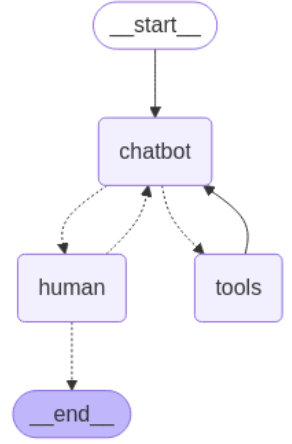

* The **conversation history** as well as other auxiliar variables are managed accross the graph nodes with the **LangGraph's shared state system** to ensure persistent memory between steps.



### Important note:

Once the user requests publication, the chatbot will respond with a formatted list. For each article in the list, the corresponding URL to access the PDF file (retrieved from OpenAlex) will be provided. If the user wishes to explore one of the listed papers, they will indicate the ID of the paper. Upon receiving the ID, the agent will call the appropriate tool ("download_paper_openalex_url"), with the paper's URL as the input parameter. This tool uses Python's requests library to get the file. 

Although request headers are added, some websites qill reject the download request, resulting in a "403 Forbidden" error. In such cases, the agent should inform the user that it was not possible to load the file automatically. The user can choose another article to explore. 

If the user wants to explore that paper whose download failed, they can still load the pdf file into kaggle's working directory, with file name "article.pdf". This can be done, for example, using a Google Drive sharing link (sharing option: "Anyone with the link can download"). A function called **"load_paper_googledrive"** is added to the end of this notebook and can be used for this purpose. It accepts the *Google Drive link* and stores the file as /kaggle/working/article.pdf. Once the file is loaded successfully, the agent should directly call the tool "create_embeddings_paper" to continue processing. Note that the current code should be adjusted accordingly to handle this flow properly, as it is not fully adapted to this behaviour yet.

## Project:

### 1) Set up:

Install packages and set the GOOGLE_API_KEY (this key should be added and activated previously - Add-ons >  Secrets).

In [ ]:
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
!pip install -qU 'async-timeout==4.0.3' 
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

In [ ]:
# Packages used for RAG:
!pip install -qU "google-genai==1.7.0" "chromadb==0.6.3"
!pip install langchain langchain-community

In [ ]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

### 2) Defining shared state (LangGraph) and core instructions:

Analysis State includes the shared state (a structured dictionary - TypeDict) that defines fields that will persist and can be updated accross different nodes in the graph. The main instructions that are given to the model, as well as a welcome message, are also included since those will be sent when the model is invoked.


In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
    
class AnalysisState(TypedDict):
    """State representing the conversation (messages) and finished state"""

    messages: Annotated[list, add_messages]   
    finish_conversation: bool

MAIN_INSTRUCTIONS = (
    "system", 
    (
        """
        You are a (conversational) research assistant who helps users find and explore scientific publications based on the given procedures:

        The user might:
        Option 1) Ask for publications on a specific topic and criteria
        Option 2) Ask for publications on a specific topic and criteria and want to explore a specific paper (with an ID)
        Option 3) Want to explore a specific paper (without needing to ask for a publication list)

        Important note:
        You will not search for papers by yourself, but you will present the list to the user in a readable way. To get the list follow the EXACT 
        instructions indicated bellow and the "Query string instructions". 
        
        After showing the list to the user, you should ask the user to indicate the ID of the paper to explore. If the user identifies a valid ID, 
        get the URL associated to that paper (indicated in the list) and call the tool "download_paper_openalex_url" with the url as input param, to 
        load the pdf file (the content of the file will be made available to help you answer the questions the user will do next).
                
        Once the file was successfully loaded (using the "download_paper_openalex_url"), call the tool "create_embeddings_paper" to create the 
        embeddings of the document.
        
        When the user asks questions related to a specific paper (the paper the user choose to explore - indicating its ID), you should 
        call the tool "retriever" to get the parts of the paper that contain information related to the question made by the user. Then, use the 
        retrieved content as context to answer the user's question accurately.
        
        The user will ask questions about the content of that paper. You will answer those questions ONLY based on the content of that paper. 
        If you cannot find the answer in the paper, politely inform the user and recommend reading a section of the paper that might contain 
        the information. 

        """
    ),
)

ADDITIONAL_INSTRUCTIONS = (
    "system",  
    (
        """      
        If the user asks for publications about a specific topic (search terms) and eventually indicates specific criteria 
        such as number of citations and year, you can ONLY respond with one of these: 
        
        Option 1: If the user message is clear:
                 1) Translate the user message into a {query string} (that you will generate strictly following the 'Query string instructions'),
                 2) Place the {query_string} into this URL (where the placeholder is):
                   "https://api.openalex.org/works?filter={query_string},is_oa:true&select=id,relevance_score,title,type,primary_location,publication_year,authorships,doi,open_access,cited_by_count&sort=relevance_score:desc"
                 3) Call the tool "get_publications_list" using the URL obatined in step 2) as input param. Do not show any raw URL or query string
                    to the user. Instead, call the tool so that the publication list is retrieved and then show to the user ONLY the formatted
                    publication list. The formated list should include only the id number, title, year, authors and url, according to his format:
                    EXAMPLE:
                    1) Recent Trend of Inverter and its Control Method for Electric Car. (2000)  
                       Tomoki Watanabe  
                       (https://www.jstage.jst.go.jp/article/rtriqr/41/1/41_1_5/_pdf)
                    ...
                    
        Option 2: If the user message is not clear:
                  1) Ask for clarification in case the terms provided and/or the criteria are not clear. 
                
        Publications list will be retrieved by the OpenAlexAPI, and will be get using the generated URL and the tool get_publications.


        "Query string instructions": 
        
        - If no criteria are provided or if the user requests publications BUT the criteria are unclear and/or the search terms 
        don’t contain recognizable words, ask the user to clarify or give another search terms. 
        - If search terms and criteria are clear: Generate query strings based on these criteria: 
            1) **Publication Year**: could be a single or range of years. 
                - Single year: 'publication_year:{YEAR}' --> (where {YEAR} is the specific year). 
                - Range: 'publication_year:%3E{YEAR_START},publication_year:%3C{YEAR_END}' --> (where {YEAR_START} and {YEAR_END} are the start and end years). 
                - After: 'publication_year:%3E{YEAR_L}' --> (where {YEAR_L} is the start year). 
                - Before: 'publication_year:%3C{YEAR_H}' --> (where {YEAR_H} is the end year). 
            2) **Citations Count**: could be a single value or a range of values. 
                - Single value: 'cited_by_count:{NUMBER}' --> (where {NUMBER} is the specified citation count). 
                - Range: 'cited_by_count:%3E{LOW_CITATION_NUMBER},cited_by_count:%3C{HIGH_CITATION_NUMBER}' 
                  (where {LOW_CITATION_NUMBER} and {HIGH_CITATION_NUMBER} are the lower and upper bounds). 
                - More than: 'cited_by_count:%3E{CITATION_NUMBER_L}' --> (where {CITATION_NUMBER_L} is the minimum number of citations). 
                - Less than: 'cited_by_count:%3C{CITATION_NUMBER_H}' --> (where {CITATION_NUMBER_H} is the maximum number of citations). 
            3) **Search Terms**: 'default.search:{CONCATENATED_MAIN_SEARCH_TERMS}' --> 
                (where {CONCATENATED_MAIN_SEARCH_TERMS} is the string of main search terms concatenated using plus signs (+) to replace spaces). 
        
        If more than one criterion is met, generate separate strings for each criterion and concatenate them using commas (,). 
        The default.search-related query must always be present! If no criteria are provided or are unclear, return empty query string (''), 
        i.e., an empty string.

        EXAMPLE:
        User message: "Can you help me find papers about electric cars from 2020?"
        Response: default.search:electric+cars,publication_year:2000
        
        """
    ),
)

WELCOME_MESSAGE = (
    "Hello! I can help you explore open-source scientific articles on a topic of your choice. "
    "Start by providing some keywords related to the topic you're interested in, and if you want, specific criteria (year, citations). "
    "Then, choose a paper from the list to exploreGOOGLE_API_KEY, and feel free to ask questions about it!",
)

### 3) Defining the model (LLM):

In this case, the "gemini-2.0-flash" model was used.


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

### 4) Defining the initial graph structure with the main nodes:

Two main nodes were created: "chatbot" and "human" nodes. These LangGrah nodes each take the shared state (here defined as AnalysisState) as input and return the updated state.

* The **"chatbot"** node integrates with the LLM. If there are no prior messages, it sends an initial greeting. Otherwise, it invokes the model using the provided message history along with the instructions.
* The **"human"** node handles user input, prompting the user via Python's input() function. It also allows the user to end the conversation by typing expressions like "q", "quit", "exit" and "goodbye" - setting the finish_conversation flag in state.

The graph starts from the **START** node, immediatly moves to **"chatbot"** and then continues to **"human"** to receive the user's reply, enabling interaction.

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage

def chatbot(state: AnalysisState) -> AnalysisState:

    INITIAL_MESSAGE = "Hello! I can help you find publications on any topic you want. Let me know about key terms as well as criteria related to publication year and minimum number of citations"
    
    if not state["messages"]:
        new_message = AIMessage(content=INITIAL_MESSAGE)
    else:
        new_message = llm.invoke([MAIN_INSTRUCTIONS] + [ADDITIONAL_INSTRUCTIONS] + state["messages"])

    return state | {"messages": [new_message]}

def human_node(state: AnalysisState) -> AnalysisState:
    last_message = state["messages"][-1]
    print("Model: ", last_message.content)

    user_input = input("User: ")
    # If the user types any of these expressions, update the state "finish_conversation":
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finish_conversation"] = True

    return state | {"messages": [("user", user_input)]}
    

graph_builder = StateGraph(AnalysisState)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("human", human_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot","human")
        

Concerning the termination of the graph execution, that is handled conditionally (setting a conditional edge) and occurs when the state "finish_conversion" is set to True.

In [ ]:
from typing import Literal


def maybe_exit_human_node(state: AnalysisState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finish_conversation", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

Compiling the initial graph and rendering the graph structure as a mermaid diagram:

(Note that this system doesn't include any Tools. Those will be added next and the graph will be updated.)

In [ ]:
from IPython.display import Image, display

assistant_graph = graph_builder.compile()
Image(assistant_graph.get_graph().draw_mermaid_png())

### 5) Defining the tool to allow fetching the publications list from OpenAlex API:

The function "get_publications_list" receives an url and returns a list of publications. This tool will be made available to the model later, so it can get the publications list when the user asks for it.

The url is generated by the model, after interpreting the user's requirements and following specific instructions ("Query string instructions").

Only the main information about each publication is stored, including: title, authors, publication year and url to access the pdf file of the article.


In [ ]:
from langchain_core.tools import tool
import requests

@tool
def get_publications_list(url: str) -> str:
    """Get the publications list from OpenAlex API using the generated URL"""
    
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        results = data.get("results")
        publications_list = []
        publications_list_string = ""
        
        for result in results:
            title = result.get("title")
            year = result.get("publication_year")
            url = result.get("primary_location", {}).get("pdf_url")
            authorships = result.get("authorships", [])
            authors_list = []
    
            for author in authorships[:3]:
                author_name = author.get("author",{}).get("display_name")
                if author_name:
                    authors_list.append(author_name)

            if len(authorships) > 3:
                authors_list.append("et al.")
    
            publications_list.append({
                "title": title,
                "year": year,
                "authors": authors_list,
                "url": url
            })    

        i=1
        for publication in publications_list:
            publications_list_string += f"id: {i}, title: {publication['title']}, year: {publication['year']}, authors: {', '.join(publication['authors'])}, url: {publication['url']}, "
            i = i+1

        return publications_list_string
        
    else: 
        print(f"Error: {response.status_code}")
        
        return publications_list_string #empty string

### 6) Defining a custom embedding funtion, to be used in RAG:

In this case, the model **"models/text-embedding-004"** is used to create the embeddings. Those are created by calling the embed_content API from Google's Generative AI client. Depending on the document_mode flag, it adjust whether embeddings are associated to documents or user queries. An instance of GeminiEmbeddingFunction is created and stored in embed_function, which will be accessed by the tools defined later (tools for embedding and retrieving).

In [ ]:
import chromadb
from google import genai
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry

from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})


class GeminiEmbeddingFunction(EmbeddingFunction):

    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:

        embedding_task = "retrieval_document" if self.document_mode else "retrieval_query"

        try:
            response = client.models.embed_content(
                model="models/text-embedding-004",
                contents=input,
                config=types.EmbedContentConfig(
                    task_type=embedding_task,
                ),
            )

            if response and hasattr(response, 'embeddings'):
                return [e.values for e in response.embeddings]
            else:
                raise ValueError("Unexpected API response: Missing embeddings.")
        
        except genai.errors.APIError as e:
            print(f"APIError encountered: {e}")
            if hasattr(e, 'response'):
                print(f"Error response: {e.response}")
            raise e  # Re-raise the error for further handling or logging
        
        except Exception as e:
            print(f"Unexpected error occurred: {e}")
            raise e

embed_function = GeminiEmbeddingFunction()

### 7) Defining the tool to download the pdf of the selected paper (to explore) and store it into the working directory:

The function "download_paper_openalex_url" receives the URL of the publication selected by the user (for exploration) and downloads the corresponding PDF file into Kaggle's working directory, saving it with the filename "article.pdf". 

(This url is provided in the information associated with the paper, retrieved by the OpenAlex API). 

**Note**: Depending on the website, it might not be possible to download the paper. Although headers were added to the request, in some cases a "403 Forbidden" error may occur. When that happens, the model will notify the user that it was not possible to load the file and ask them to choose another paper. 
If the user still wants to explore a paper that cannot be loaded in this way, they can add the file into Kaggle's working directory using a Google Drive sharing link. A function called "load_paper_googledrive" is provided at the end of this notebook for that purpose. However, the code must be adjusted accordingly, as the current implementation does not yet suppot this workflow.

In [ ]:
import requests
import time
from langchain_core.tools import tool

@tool
def download_paper_openalex_url (url: str, retries: int = 3, delay: int = 5):
    """ Download the PDF (article pdf file) using the url of the article, indicated in the Publication 
    List (information provided by OpenAlex API) """
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) " \
                      "AppleWebKit/537.36 (KHTML, like Gecko) " \
                      "Chrome/122.0.0.0 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
    }
    attempt = 0

    filename = "/kaggle/working/article.pdf"
    
    while attempt < retries:
        try:
            response = requests.get(url, headers=headers, timeout=15)
            
            if response.status_code == 200:
                with open(filename, "wb") as f:
                    f.write(response.content)
                print(f"Downloaded {filename} successfully")
                
                return True
            else:
                print(f"Attempt {attempt+1}: Failed with status {response.status_code}. Retrying...")
                
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt+1}: Request failed: {e}. Retrying...")

        attempt += 1
        time.sleep(delay)

    print(f"Failed to download after {retries} attempts.")
    return False

### 8) Defining the tool to create the embeddings (document):

The function "create_embeddings_paper" is a tool that loads and embeds the selected research paper, preparing for retrieval. 

It loads the the PDF file using PyPDFLoader, then splits the document into smaller overlapping text chunks using LangChain's RecursiveCharacterTextSplitter. The embed_function is set to document mode (since it is embedding the document) and a persistent Chroma database is used to store the generated embeddings.

In [ ]:
from langchain_core.tools import tool
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

from google.api_core import retry
from google import genai
from google.genai import types

import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings


# Shared state dictionary used to store the db obj - to be accessible to "retriever" tool:
shared_state = {}

@tool
def create_embeddings_paper () -> str:
    """Load and embed the paper to explore - Necessary to respond user's questions about the paper"""
    
    try:
        filename = "/kaggle/working/article.pdf"
        loader = PyPDFLoader(filename)
        documents = loader.load()
    
        # Dividing the content into several chunks with limited size and allowing overlapping 200 characters to preserve the context:
        text_splitter = RecursiveCharacterTextSplitter(chunk_size = 3000, chunk_overlap=200, length_function=len, separators=["\n\n", "\n", " "])
        chunks = text_splitter.split_documents(documents)
        #print(f"Chunks: {chunks[:5]}") 
        #print(f"nº of chunks = {len(chunks)}")
        
        # keeping their content:
        text_chunks = [chunk.page_content for chunk in chunks]

        embed_function.document_mode = True

        chroma_client = chromadb.PersistentClient(path="/kaggle/working/chroma_db")
        db = chroma_client.get_or_create_collection(name="article_db", embedding_function=embed_function)
        shared_state["db"] = db
    
        db.add(documents=text_chunks, ids=[str(i) for i in range(len(text_chunks))])
        # print("Checking number of documents in DB:", db.count())
    
        return "Document embeded successfully"
    
    except Exception as e:
        print(f"Error during embedding: {e}")
        return f"Error: {e}"

### 9) Defining the tool to retrieve relevant documents based on the users query (semathinc similarity):

The function "retriever" gets the most relevant parts of the document (previously embedded) taking into account the user's query. It access to the chroma database and performs a similarity search, retrieving (in this case) the most relevant text chunk. That text chunk is then returned by the function and will be considered by the model as context to respond the user's question.

In [ ]:
from langchain_core.tools import tool
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

from google.api_core import retry
from google import genai
from google.genai import types

import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings

@tool
def retriever (user_question: str) -> str:
    """Get the most relevant parts of the article (selected to explore) associated with the user's question."""

    embed_function.document_mode = False
    # print("embed_function.document_mode", embed_function.document_mode)
    db = shared_state.get("db")
    
    if db is None:
        print("Error: DB is not initialized.")
        return "Error: Database not available."

    try:
        result = db.query(query_texts=[user_question], n_results=1)
        [relevant_chunks] = result["documents"]
        # print("Relevant chunks:", relevant_chunks)
        return relevant_chunks
        
    except Exception as e:
        print("Error during retrieval:", e)
        return f"Error: {str(e)}"

### 10) Binding the tools defined previously to the model and adding conditional edge to allow routing to tools:

The tools: "get_publications_list", "download_paper_openalex_url", "create_embeddings_paper", "retriever" are made available and assigned to a ToolNode. This allows the model to be "aware" of those tools and call them when needed (depending on the user's messages). Also, a conditional routing mechanism is defined, which checks the last message and determines whether the flow should move to "tools" node or to "human" node.

In [ ]:
from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_publications_list, download_paper_openalex_url, 
         create_embeddings_paper, retriever]

tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: AnalysisState) -> Literal["tools", "human"]:
    """Route between chatbot or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"

### 11) Updating the chatbot node to integrate last changes (binding tools to the model) and setting up the graph edges:

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage

def chatbot_with_tools(state: AnalysisState) -> AnalysisState:

    INITIAL_MESSAGE = "Hello! I can help you find publications on any topic you want. Let me know about key terms as well as criteria related to publication year and minimum number of citations"
    
    if not state["messages"]:
        new_message = AIMessage(content=INITIAL_MESSAGE)
    else:
        new_message = llm_with_tools.invoke([MAIN_INSTRUCTIONS] + [ADDITIONAL_INSTRUCTIONS] + state["messages"])
    

    return state | {"messages": [new_message]}


graph_builder = StateGraph(AnalysisState)

graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

assistant_graph_with_tools = graph_builder.compile()

### 12) Checking the final graph's structure:

In [ ]:
Image(assistant_graph_with_tools.get_graph().draw_mermaid_png())

### 13) Testing the chatbot:

In [ ]:
config = {"recursion_limit": 100}
state = assistant_graph_with_tools.invoke({"messages": []}, config)

#### NOTE: Function to download a PDF file into Kaggle's working directory using Google Drive sharing link:

In [ ]:
# Setup Gdrive file download extention 
!pip install gdown

In [ ]:
import re
import gdown
from langchain_core.tools import tool
import mimetypes
import os

# replace by your Google Drive's sharing link (sharing options: Available to anyone with this link)
url = "https://drive.google.com/file/d/.../view?usp=sharing"


def load_paper_googledrive (url: str) -> str:
    """ Download the PDF (article pdf file) from a given Google Drive sharing link """
    print("IN DOWNLOAD PAPER - THIS IS THE URL RECEIVED", url)
    try:
        
        extract_id = re.search(r'/d/([a-zA-Z0-9_-]+)', url)
        
        if not extract_id:
            print("Could not extract the ID of the Google drive sharing link")

        file_id = extract_id.group(1) # without the /d/
        
        download_url = f'https://drive.google.com/uc?id={file_id}' 
        print(download_url)
        
        article = gdown.download(download_url, "article.pdf", quiet=False)

        if article is None:
            raise Exception("Download failed or file not found.")

        if not os.path.exists(article):
            raise FileNotFoundError("Downloaded file does not exist.")
        
        print("PDF successfully downloaded from google drive link")
        return article
    except Exception as e:
        print(f"Error during download or validation: {e}")
        return f"Error: {e}"
    
#load_paper_googledrive(url)